<a href="https://colab.research.google.com/github/ipavlopoulos/palit/blob/main/xai_in_the_dating_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAI in the loop of dating
* Execute the following cells

In [1]:
#@title Source code
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

import numpy as np
import pandas as pd
import skimage
from skimage import transform
from sklearn.preprocessing import OneHotEncoder

from tqdm.notebook import tqdm

class fCNNc(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.CNN = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
        )

        self.MLP = nn.Sequential(
            nn.Linear(41472, 1024, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.1, inplace=True),

            nn.Linear(1024, 512, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.1, inplace=True),

            nn.Linear(512, n_classes, bias=True)
        )

    def forward(self, x):
        x = self.CNN(x.unsqueeze(1))
        x = torch.flatten(x, 1)
        x = self.MLP(x)
        return x

def test_clf(model, dataloader, device="cpu"):
    prediction_list = []
    model.eval()
    with torch.no_grad():
        for id_batch, (inputs, _) in enumerate(dataloader):
            inputs = inputs.to(device)
            model.to(device)
            outputs = model(inputs)
            predictions = np.argmax(outputs.cpu().detach().numpy(), axis=1)
            prediction_list.append(predictions)
    return np.concatenate(prediction_list)

# the model predicts the average - high variance
def validate_clf(model, dataloader, device="cpu", criterion = nn.CrossEntropyLoss()):
    prediction_list, labels_list = [], []
    model.eval()
    loss = 0
    with torch.no_grad():
        for id_batch, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            model.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            labels = np.argmax(labels.cpu().detach().numpy(), axis=1)
            predictions = np.argmax(outputs.cpu().detach().numpy(), axis=1)
            prediction_list.append(predictions)
            labels_list.append(labels)
    p = np.concatenate(prediction_list)
    g = np.concatenate(labels_list)
    acc = accuracy_score(g, p)
    return p, g, loss, acc

def train_clf(model, dataloader, optimizer, criterion=nn.CrossEntropyLoss(), val_dataloader=None, patience=3, N_EPOCHS=100, device="cpu"):
    losses, mae_losses, val_losses, train_losses = [], [], [], []
    dataset_size = len(dataloader.dataset)
    lowest_error = 100000
    best_epoch = -1

    for epoch in range(N_EPOCHS):
        print(f"\nEpoch {epoch + 1}\n-------------------------------")
        train_loss = 0
        # Loop over batches in an epoch using DataLoader
        for id_batch, (inputs, labels) in enumerate(dataloader):
            model.train()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        if val_dataloader is not None:
            if (patience>0) and (epoch-best_epoch>patience-1) and epoch > 50:
                print("Max patience reached, now loading the best checkpoint...")
                model.load_state_dict(torch.load("checkpoint.pt"))
                print("Exiting...")
                break
            predictions, labels, val_loss, val_acc = validate_clf(model, val_dataloader, device=device)
            val_losses.append(val_loss)
            train_losses.append(train_loss)
            # ignore majority perfomance
            if (patience>0) and (val_loss<lowest_error):
                lowest_error = val_loss
                best_epoch = epoch
                torch.save(model.state_dict(), "checkpoint.pt")
            print(f"Train loss: {train_loss:.2f}, Val loss: {val_loss:.2f}, Val acc: {val_acc:.2f}")
            print(f"Best Epoch: {best_epoch+1} (Val loss: {lowest_error:.2f})")
            print(f"[val var: {np.var(predictions):.2f}, min-max: {min(predictions):.2f}-{max(predictions):.2f}]")
    model.eval()
    return model, train_losses, val_losses

class ImageDataset(TensorDataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = np.array(self.dataframe['date'])
        self.labels = np.reshape(self.labels, (self.labels.shape[0], 1))
        self.labels = OneHotEncoder(sparse=False).fit_transform(self.labels)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        sample, date = self.dataframe.iloc[idx].img.astype(np.float32), self.labels[idx]
        if self.transform is not None:
            sample = self.transform(sample)
            sample = sample.reshape(sample.shape[1], sample.shape[2]) # grayscale
        return sample, date # 1CE-4CE

augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(3), # turn
    transforms.RandomResizedCrop((50, 300), scale=(0.75, 1.0), ratio=(1, 6)), # crop n scale (add scale to control this)
    #transforms.RandomCrop((30, 30)),
    transforms.GaussianBlur(3), # blur
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, value=0.5), # erase
])

cc_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((50, 300)),
    transforms.ToTensor(),
])

rs_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50,300)),
    transforms.ToTensor(),
])

white_fragment_ablation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50,300)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=1, value=1), # add a white box
])

black_fragment_ablation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50,300)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=1, value=0), # add a black blox
])

class fCNNr(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(41472, 1024, bias=True) # 108928 if the 2nd ConvNet is active
        self.fc2 = nn.Linear(1024, 512, bias=True)
        self.dropout = nn.Dropout(0.1)
        self.fc3 = nn.Linear(512, 1, bias=True) # regression output

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x.unsqueeze(1))))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.dropout(x) # our augmentation is competitive to dropout at the input (yet locally coherent)
        x = self.fc3(x)
        return x


def test_reg(model, dataloader, device="cpu"):
    predictions = []
    with torch.no_grad():
        for id_batch, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            model.eval()
            model.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy()[:, 0])
    return predictions


# the model predicts the average - high variance
def validate_reg(model, dataloader, device="cpu"):
    predictions, gold_labels = [], []
    with torch.no_grad():
        for id_batch, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            model.eval()
            model.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy()[:, 0])
            gold_labels.extend(labels.cpu())
    return predictions, gold_labels

def train_reg(model, dataloader, optimizer, criterion, val_dataloader=None, patience=3, val_metric = mean_absolute_error, n_print=10, N_EPOCHS=4, device="cpu"):
    losses, mae_losses, val_losses, train_losses = [], [], [], []
    dataset_size = len(dataloader.dataset)
    lowest_error = 100000
    best_epoch = -1
    for epoch in range(N_EPOCHS):
        print(f"Epoch {epoch + 1}\n-------------------------------")

        # Loop over batches in an epoch using DataLoader
        for id_batch, (inputs, labels) in enumerate(dataloader):
            model.train()
            inputs, labels = inputs.to(device), labels.float().flatten().to(device)
            outputs = model(inputs).flatten()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print the loss for this batch (every n batches, plus the # examples)
            if id_batch % n_print == 0:
                loss, current = loss.item(), (id_batch + 1) * len(inputs)
                losses.append(loss)
                mae = nn.L1Loss()
                mae_loss = mae(outputs, labels)
                mae_losses.append(mae_loss)
                print(f"loss: {loss:.2f} (@all: {np.mean(losses):.2f}) mae: {mae_loss:.2f}  [{current:>2d}/{dataset_size:>2d}]")

        if val_dataloader is not None:
            if (patience>0) and (epoch-best_epoch>patience-1):
                print("Max patience reached, now loading the best checkpoint...")
                model.load_state_dict(torch.load("checkpoint.pt"))
                print("Exiting...")
                break
            predictions, labels = validate(model, val_dataloader, device=device)
            val_error = val_metric(predictions, labels)
            train_predictions, train_labels = validate(model, dataloader, device=device)
            train_error = val_metric(train_predictions, train_labels)
            val_losses.append(val_error)
            train_losses.append(train_error)
            if (patience>0) and (val_error<lowest_error):
                lowest_error = val_error
                best_epoch = epoch
                torch.save(model.state_dict(), "checkpoint.pt")
            print(f"Train loss: {train_error:.2f}, Val loss: {val_error:.2f}, Best Epoch: {best_epoch+1} (Val loss: {lowest_error:.2f}) [val var: {np.var(predictions):.2f}, min-max: {min(predictions):.2f}-{max(predictions):.2f}]")
    return losses, mae_losses, train_losses, val_losses

class ImageDatasetReg(TensorDataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        sample, date = self.dataframe.iloc[idx].img.astype(np.float32), self.dataframe.iloc[idx].date
        if self.transform is not None:
            sample = self.transform(sample)
            sample = sample.reshape(sample.shape[1], sample.shape[2]) # grayscale
        return sample, date


In [2]:
#@title Download the model
%%capture
!gdown 1ogdiEKqXRxzJShaBp2AYEGlKYma-wKwE

fcnnc = fCNNc(n_classes=4)
fcnnc.load_state_dict(torch.load('fewlines_split-checkpoint.pt', map_location=torch.device('cpu')))

In [3]:
# @title The saliency
import matplotlib.pyplot as plt
import seaborn as sns
def saliency(model, inputs, labels, device='cpu', confidence=False):
    model.eval()
    inputs = inputs.to(device).requires_grad_(requires_grad=True)
    labels = labels.to(device)
    outputs = model(inputs).to(device)
    # yield the prediction in CE
    pred_date = np.argmax(outputs.cpu().detach(), 1).numpy()[0]+1
    if confidence:
      # plot the distribution over the centuries
      print(pd.Series(outputs.detach().numpy()[0],
                      index=['1 CE','2 CE','3 CE','4 CE']).plot.bar(figsize=(4,1), rot=0));
      sns.despine(left=True, bottom=True)
    # compute the saliency maps
    criterion = nn.CrossEntropyLoss().to(device)
    loss = criterion(outputs, labels)
    loss.backward()
    batch_grad = inputs.grad.cpu().detach().numpy()
    batch_grad = np.squeeze(batch_grad)
    batch_grad = np.absolute(batch_grad)
    # plot (saliency on top of the image)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(batch_grad, cmap='hot', interpolation='nearest', zorder=1)
    ax.imshow(np.squeeze(inputs.cpu().detach().numpy()), cmap='gray', zorder=2, alpha=0.3)
    ax.set_title(f'Predicted as {pred_date} CE');
    return fig, ax, outputs.detach()

# Upload/Date
* Upload one image at a time by executing the cell below.
* Execute the cell after the `upload` to date the uploaded image.
* Repeat as many times as wanted, no need to execute the previous cells.

Saving P.Bodmer24_18r_uid51.jpeg to P.Bodmer24_18r_uid51 (1).jpeg


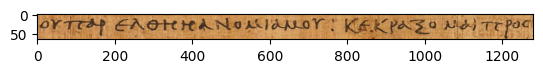

In [10]:
#@title Upload an image (at a resolution equal or higher than 50x300)
from google.colab import files
uploaded = files.upload()
fname = list(uploaded.keys())[0]
img = skimage.io.imread(fname)[:,:,:3]
plt.imshow(img, cmap='gray');

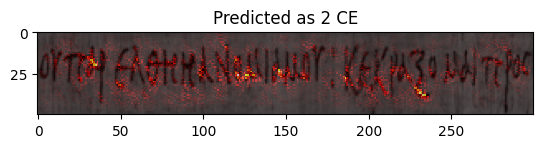

In [11]:
#@title Date and explain
binarise = lambda img: img if len(img.shape)<3 else skimage.color.rgb2gray(img)
loader = DataLoader(ImageDatasetReg(pd.DataFrame({'img': [binarise(img)], 'date': [0]}),
                                    transform=rs_transform), batch_size=1)
device = 'cpu'
for image, label in loader:
  fig, axs, outputs = saliency(fcnnc, image, label);